# Visualisation et statistiques descriptives des données

Dans ce notebook, les données de train et d'input sont visualisé pour en comprendre les patterns.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import datashader as ds
import datashader.transfer_functions as dtf

from bokeh.palettes import GnBu9
from datashader.colors import colormap_select as cm, inferno, viridis
from datashader.utils import lnglat_to_meters
from IPython.display import display, HTML, Markdown
from matplotlib.colors import LinearSegmentedColormap

In [5]:
%matplotlib inline
mpl.rcParams['figure.dpi'] = 130

plasma = [tuple(df) for df in mpl.cm.plasma(range(255), bytes=True)[:, 0:3]]

width = 5000

# plot buildings
#cvs = ds.Canvas(plot_width=width, plot_height=int(width / ratio), **quebec)
# agg = cvs.points(df, 'x', 'y', ds.mean('Annee_Const'))
# img = dtf.shade(agg, cmap = cm(plasma, 0.3), how='eq_hist' , min_alpha=20)

# display(Markdown("### Building density"))
# display(bg(img))

# def bg(img): return dtf.set_background(img, "black")

# def plot_points(df, func=ds.count(), width=2000, how='eq_hist', 
#                 min_alpha=100, spread=0, cmap=cm(plasma, 0.2), color_key=None):
    
#     ratio = (df.x.max() - df.x.min()) / (df.y.max() - df.y.min())
    
#     cvs = ds.Canvas(plot_width=width, plot_height=int(width/ratio))
#     agg = cvs.points(df, 'x', 'y', func)
#     img = dtf.shade(agg, cmap=cmap, how=how, min_alpha=min_alpha, color_key=color_key)
            
#     if spread > 0:
#         img = dtf.spread(img, px=spread)
    
#     display(bg(img))
    
# def plot_colorbar(labels, cmap=None, palette=None):
#     fig = plt.figure(figsize=(10, 3))
#     fig.add_axes([0.05, 0.80, 0.9, 0.15])
#     if not cmap:
#         cmap = mpl.cm.cool.from_list('cus01', palette)
#     cb = mpl.colorbar.ColorbarBase(ax=fig.axes[0], cmap=cmap, orientation='horizontal')
#     cb.set_ticks([0,1])
#     cb.set_ticklabels(labels)

In [6]:
train = pd.read_csv("../data/raw/mlt_3c_2018-11-16.csv", sep = ";")
pred = pd.read_csv("../data/raw/ev2_pred_3c_mtl_2018-11-15.csv", sep = ';')

## Data cleaning

In [7]:
train.dropna(axis = 0, inplace = True)
train = train.query("MONTANT < 2000000")

pred = pred.query("MONTANT < 2000000")

##  Trainset

Pour le trainset, les graphiques voulus sont:

    1- Nombre de transactions relativement au temps.
    
    2- Densite du prix / du prix en log
    
    3- Superficie
    
    4- Map avec la position des X, Y. 

### Transaction / temps

In [8]:
train.head()

IDUEF    TRA_DATE  MONTANT      IMM_X      IMM_Y
0   4140469  2018-03-19   255000 -73.923665  45.415576
1  10953291  2018-04-23   385000 -73.924912  45.414897
2   4152720  2018-04-11   362000 -73.924443  45.415285
3   4127905  2018-04-16   247000 -73.922557  45.415931
4   4127910  2018-05-07   255000 -73.922557  45.415931

In [9]:
train['TRA_DATE'] = pd.to_datetime(train['TRA_DATE'])
train['week'] = train.TRA_DATE.dt.strftime('%Y-w%U')

In [10]:
count_by_week = train.groupby('week').agg('count')
count_by_week.reset_index(inplace =True)
count_by_week.head()

week  IDUEF  TRA_DATE  MONTANT  IMM_X  IMM_Y
0  2018-w00     32        32       32     32     32
1  2018-w01    120       120      120    120    120
2  2018-w02    165       165      165    165    165
3  2018-w03    126       126      126    126    126
4  2018-w04    159       159      159    159    159

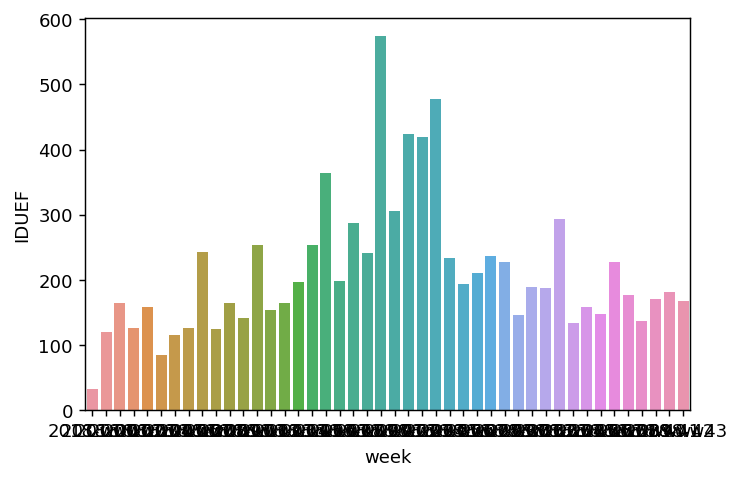

In [11]:
sns.barplot(x = 'week', y = 'IDUEF', data = count_by_week)

### Prix / prix en log

In [12]:
sns.distplot(train.MONTANT)

c:\users\charlesd\envs\gc2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


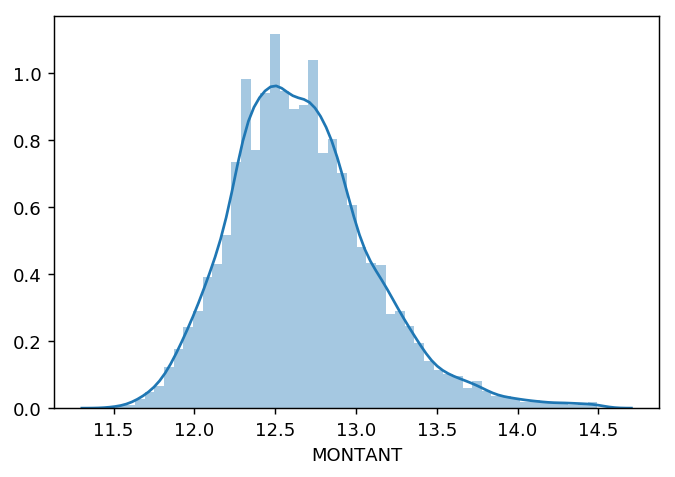

In [13]:
sns.distplot(np.log(train.MONTANT))

### Statistiques descriptives du prix de transactions

In [14]:
prix = train.MONTANT
print("Le prix minimum: {} $".format(np.min(prix)))
print("Le prix maximum: {} $".format(np.max(prix)))
print("Le prix moyenne: {} $".format(round(np.mean(prix))))
print("Le prix median: {} $".format(np.median(prix)))

Le prix minimum: 100180 $
Le prix maximum: 1969851 $
Le prix moyenne: 352199.0 $
Le prix median: 305000.0 $


### Maps des proprietes

In [15]:
map_df = train[['IMM_X', 'IMM_Y', 'MONTANT']].copy()
map_df['x'], map_df['y'] = lnglat_to_meters(map_df['IMM_X'], map_df['IMM_Y'])
map_df.head()

IMM_X      IMM_Y  MONTANT             x             y
0 -73.923665  45.415576   255000 -8.229145e+06  5.687184e+06
1 -73.924912  45.414897   385000 -8.229284e+06  5.687077e+06
2 -73.924443  45.415285   362000 -8.229231e+06  5.687138e+06
3 -73.922557  45.415931   247000 -8.229021e+06  5.687241e+06
4 -73.922557  45.415931   255000 -8.229021e+06  5.687241e+06

In [16]:
display(Markdown("### House prices - Montreal (non linear scale)"))
plot_points(map_df, func=ds.mean('MONTANT'), cmap=inferno, how='eq_hist', min_alpha=20)
plot_colorbar([int(map_df.MONTANT.min()), int(map_df.MONTANT.max())], cmap=mpl.cm.inferno)

### House prices - Montreal (non linear scale)

NameError: name 'plot_points' is not defined

## Prediction dataset

1- Graphique des prix / prix en log

2- Map des X, Y

In [17]:
pred.head()

EV2_DATE    IDUEF  MONTANT IMM_CAT_BAT      IMM_X      IMM_Y
0  2018-11-15  1105543   448618          3C -73.572332  45.482101
1  2018-11-15  1105748   159234          3C -73.558542  45.525067
2  2018-11-15  1105813   254879          3C -73.575178  45.492249
3  2018-11-15  1105819   150885          3C -73.553301  45.506596
4  2018-11-15  1109051   340575          3C -73.567703  45.514957

In [18]:
sns.distplot(pred.MONTANT)

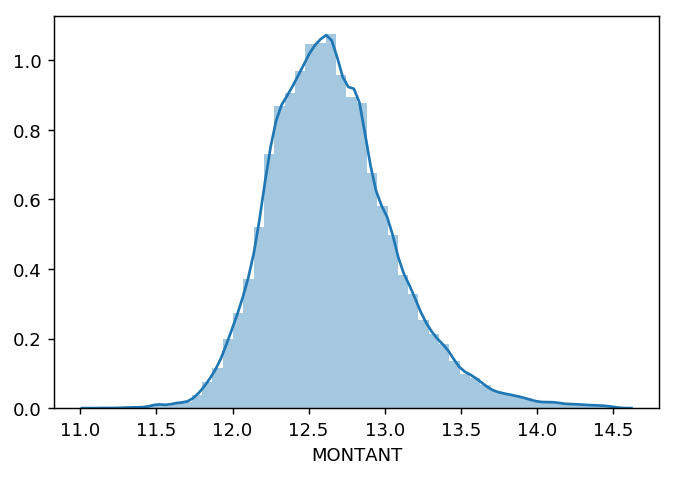

In [19]:
sns.distplot(np.log(pred.MONTANT))

In [21]:
sns.kdeplot(np.log(pred.MONTANT))
sns.kdeplot(np.log(train.MONTANT))